# Calculating Growing Degree Days from Land Surface Temperature

This Jupyter Notebook demonstrates how to calculte Growing Degree Days (GDD), or Thermal Time, based on [Planet Land Surface Temperature](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/land-surface-temp/).  We'll be using the [Statistics API](https://docs.sentinel-hub.com/api/latest/api/statistical/) to perform this analysis.

<div style="width: 75%; padding: 15px; border: 2px solid #007980; border-radius: 5px; background-color: transparent; margin-left: 0;">
  <div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="display: flex; align-items: center; flex: 0 0 50%; padding-right: 20px;">
      <svg style="margin-right: 10px; fill: #007980; width: 64px; height: 64px;" viewBox="0 0 24 24">
        <path d="M11,9H13V7H11M12,20C7.59,20 4,16.41 4,12C4,7.59 7.59,4 12,4C16.41,4 20,7.59 20, 12C20,16.41 16.41,20 12,20M12,2A10,10 0 0,0 2,12A10,10 0 0,0 12,22A10,10 0 0,0 22,12A10, 10 0 0,0 12,2M11,17H13V11H11V17Z"></path>
      </svg>
      <p style="font-size: 16px; margin: 0;">
        This notebook makes use of <a href="https://collections.sentinel-hub.com/planet-sandbox-data/" target="_blank">Planet Sandbox Data</a>. You need a Planet account in order to access this data. If you don't already have an account, you can <a href="https://www.sentinel-hub.com/create_account/" target="_blank">create a free 30 day trial</a>.
      </p>
    </div>
    <div style="flex: 0 0 50%; text-align: center;">
      <a href="https://www.sentinel-hub.com/create_account/" target="_blank" style="
        display: inline-block;
        padding: 10px 20px;
        font-size: 16px;
        font-weight: bold;
        color: #fff;
        background-color: #007980;
        border-radius: 5px;
        text-decoration: none;
        transition: background-color 0.3s ease;
        margin: 0 auto;
      " onmouseover="this.style.backgroundColor='#005960'" onmouseout="this.style.backgroundColor='#007980'">
        Start Free Trial
      </a>
    </div>
  </div>
</div>


In [1]:
import json
import numpy as np
import folium
import getpass

import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import matplotlib.dates as mdates

import sentinelhub
from sentinelhub import (
    SHConfig,
    Geometry,
    CRS,
    SentinelHubStatistical,
    DataCollection,
    SentinelHubDownloadClient,
)

### Credentials

The Sentinel Hub Python SDK requires a ```client_id``` and a ```client_secret``` which can be created in the [Dashboard app user settings](https://apps.sentinel-hub.com/dashboard/#/account/settings). You can find full instructions on setting up the client credentials in this SDK from the [SDK documentation](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). The following code will check if you have a local profile already created, and if not it will ask for the credentials and save the profile.

In [2]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("No credentials found, please provide the OAuth client ID and secret.")
    config.sh_client_id = getpass.getpass("Client ID: ")
    config.sh_client_secret = getpass.getpass("Client Secret: ")
    config.save()
    print(f"Credentials saved to {SHConfig.get_config_location()}")
else:
    print(f"Connected to Sentinel Hub")

Connected to Sentinel Hub


### Define field of interest

In this example a field of interest has been selected in Des Moines, Iowa USA. The field boundary is defined as a GeoJSON file in EPSG:4326. We will read the GeoJSON and plot the area of interest.

In [3]:
# Read a geojson containing a polygon representing an agriculture field in Iowa
with open("des_moines_FOI.geojson") as file:
    foi_json = json.load(file)

# Load GeoJSON into a shapely polygon
foi_polygon = Polygon(foi_json["features"][0]["geometry"]["coordinates"][0])

# Convert shapely polygon to a Sentinel Hub geometry
foi = Geometry(foi_polygon, crs=CRS(4326))

In [4]:
# Plot the field on an interactive map
m = folium.Map(
    location=[
        foi_polygon.centroid.coords.xy[1][0],
        foi_polygon.centroid.coords.xy[0][0],
    ],
    zoom_start=15,
    tiles="OpenStreetMap",
)
geo_j = folium.GeoJson(data=foi_polygon, style_function=lambda x: {"fillColor": "blue"})
geo_j.add_to(m)
m

### Set collection ID

[Land Surface Temperature](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/land-surface-temp/) is available through the [Subscriptions API](https://developers.planet.com/docs/subscriptions/pvs-subs/). Once the area of interest and variables are subscribed to, the data is automatically delivered into an imagery collection on Planet Insights Platform if you use the Sentinel Hub delivery option.

In this example, we will use the Land Surface Temperature collection available in [Planet Sandbox Data](https://collections.sentinel-hub.com/land-surface-temperature/sandbox-data.html).

For more information on how to call a collection ID in a request with Python, you can refer to the `sentinelhub-py` [documentation](https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html#Retrieve-data-from-collection).

In [5]:
collection_id= "8d977093-cf9e-4351-8159-90f2522c29c1"
data_collection = DataCollection.define_byoc(collection_id)

### Calculating growing degree days

Land Surface Temperature data is available twice a day: at 1330 and 0130.  We will generate a time series for the average of the these two measurement using Sentinel Hub Statistics API. A transformation is applied using parameters derived from a linear regression analaysis between LST and weather station data.  

The calulation will then be performed with a base development value of 10 degrees celcius, this value can be changed and should be set based on the crop in the field of interest. A cumulative calculation will be performed from the start date to the end date. 

We will perform the calculation with the following parameters:

- The Sandbox Data collection Land Surface Temperature `(data_collection)`
- Cumulative calculation from May 1st, 2018 to October 31st, 2018
- At the native resolution (0.01 degree -> ±1km)
- Using our previously defined function `(calculate_gdd)`
- Calculated for each day `(P1D)`
- Over the geometry our field of interest `(foi)`
- Crop base development threshold of 10 degrees celcius. 



In [6]:
def get_time_series(temp_extreme : str, 
                    time_of_interest : tuple, 
                    input_data : sentinelhub.api.base_request.InputDataDict,
                    parcel_geo : sentinelhub.geometry.Geometry,
                    config : sentinelhub.config.SHConfig) -> pd.Series:
    
    """Get time series of LST data from sentinel hub statstics API and addjust to daily temperature extreme"""

    # set parameters for max or min temperature calculation 
    if temp_extreme == 'max': 
        sensing_time = '"1330"'
        coefficient = 0.57263731
        intercept = 5.93745546

    if temp_extreme == 'min': 
        sensing_time= '"0130"'
        coefficient = 0.3175429
        intercept = 2.15137094

    # eval script for getting time series and adjusting to daily temperature extreme
    time_series_evalscript = f"""
    //VERSION=3

    function setup() {{
        return {{
            input: [{{bands: ["LST", "dataMask"]}}],
            output: [
                {{ id: "LST", bands: 1, sampleType: "FLOAT32" }},
                {{ id: "dataMask", bands: 1, sampleType: "UINT8" }}
            ],
            mosaicking: "TILE"
        }};
    }}

    // linear regression function
    function applyLinearRegression(x) {{
        return ({coefficient} * x) + {intercept}
    }}


    // Filter out scenes where the sensing time matches specified sensing time
    function preProcessScenes (collections) {{
        collections.scenes.tiles = collections.scenes.tiles.filter(function (tile) {{
            return tile.dataPath.includes("T"+{sensing_time});
        }})
        collections.scenes.tiles.sort((a, b) => new Date(b.date) - new Date(a.date));
        return collections
    }}

    // Convert Land Surface Temperature to celcius and apply linear regression
    function evaluatePixel(samples) {{

        var sample = samples[0].LST
        var nodata = samples[0].dataMask

        //convert to celcius 
        var celcius = (sample / 100) - 273.5

        //linear regression
        var air_temp = applyLinearRegression(celcius)


        return {{
            LST: [celcius],
            dataMask: [nodata]
        }};
    }}
    """
    
    # Set up Sentinel Hub request
    request = SentinelHubStatistical(
        aggregation=SentinelHubStatistical.aggregation(evalscript=time_series_evalscript, 
                                                       time_interval=time_of_interest, 
                                                       aggregation_interval="P1D", 
                                                       resolution=(0.01, 0.01)), 
                                                       input_data=[input_data],
                                                       geometry=parcel_geo,
                                                       config=config,
                                                        )

    # Make request and download response
    download_requests = [request.download_list[0]]
    client = SentinelHubDownloadClient(config=config)
    response = client.download(download_requests)

    # Format response into Pandas dataframe
    series = pd.json_normalize(response[0]["data"])
    series['date'] = pd.to_datetime(series['interval.from'])
    series['date'] = series['date'].dt.date
    series.set_index('date', inplace=True)

    series = series[['outputs.LST.bands.B0.stats.mean']].rename({'outputs.LST.bands.B0.stats.mean':temp_extreme}, axis= 1)
    series[temp_extreme] = pd.to_numeric(series[temp_extreme], errors = 'coerce')

    return series

def calculate_gdd(time_of_interest : tuple, 
                           input_data : sentinelhub.api.base_request.InputDataDict, 
                           parcel_geo : sentinelhub.geometry.Geometry, 
                           config : sentinelhub.config.SHConfig,
                           base_value : int, 
                           upper_value : int = 0) -> pd.Series:

    # get max and min temp from Sentinel Hub Statistics API 
    max_temp = get_time_series('max', time_of_interest, input_data, parcel_geo, config)
    min_temp = get_time_series('min', time_of_interest, input_data, parcel_geo, config)
    temp_extremes =  max_temp.join(min_temp, how='outer')

    # interpolate any missing days 
    temp_extremes = temp_extremes.interpolate()

    # calcualate daily thermal time 
    temp_extremes[temp_extremes < base_value] = base_value
    if upper_value != 0:
        temp_extremes[temp_extremes > upper_value] = upper_value
    
    # Apply growing degree days equation
    temp_extremes['GDD'] = (temp_extremes['max'] + temp_extremes['min']) / 2 - base_value
    temp_extremes[temp_extremes < 0] = 0 # handle any cases where daily min was greater than max 

    return temp_extremes['GDD'].cumsum()



<div class="alert alert-block alert-info">
<b>Processing Units:</b> The following code block will consume processing units.
</div>

In [7]:
# LST input data
input_data = SentinelHubStatistical.input_data(data_collection)

# start and end date 
time_of_interest = '2018-04-01', '2018-10-31'

# crop specific base value over which growth occurs
base_value = 10

gdd = calculate_gdd(time_of_interest = time_of_interest, 
                                      input_data = input_data, 
                                      parcel_geo = foi, 
                                      config = config, 
                                      base_value=base_value)

In [8]:
gdd.head()

date
2018-04-01    0.000000
2018-04-02    0.000000
2018-04-03    0.452500
2018-04-04    2.562500
2018-04-05    7.282501
Name: GDD, dtype: float64

### Plot the results

Plot Growing Degree Days against date.

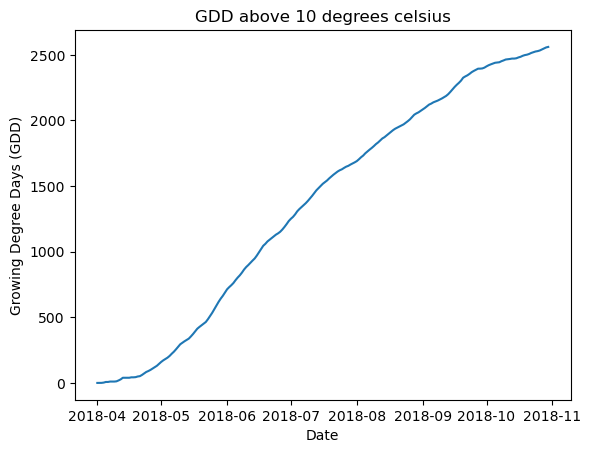

In [9]:
plt.plot(gdd.index, gdd)

plt.title('GDD above 10 degrees celsius')
plt.ylabel('Growing Degree Days (GDD)')
plt.xlabel('Date')
plt.show()

### Combining with other data sources

GDD can also be used to compare growth conditions at the same development stage across fields or years better than day of year. 

We will now index Soil Water Content for the field of interest based on the GDD rather than calander day to compare available water in the 2018, 2019 and 2020 seasons. 

First we will generate GDD for all three seasons.

In [10]:
# LST input data
input_data = SentinelHubStatistical.input_data(data_collection)

# Time of interest for each season
season_windows = [('2018-04-01', '2018-10-31'), ('2019-04-10', '2019-10-10'), ('2020-04-22', '2020-10-05')]

# crop specific base value over which growth occurs
base_value = 10

# Generate GDD for each year
gdd_data = {}

for time_of_interest in season_windows:

    gdd = calculate_gdd(time_of_interest = time_of_interest, 
                                        input_data = input_data, 
                                        parcel_geo = foi, 
                                        config = config, 
                                        base_value=base_value)
    
    gdd_data[time_of_interest[0].split('-')[0]] = gdd

Now we will extract the soil water content for our field of interest in the same time interval. 

We will use the Soil Water Content available in the Planet Sandbox Data and use the Statistics API to generate a time series of SWC data. 

In [11]:
# Set SWC collection ID as input 
collection_id= "65f7e4fb-a27a-4fae-8d79-06a59d7e6ede"
data_collection = DataCollection.define_byoc(collection_id)

In [12]:
# source SWC data in time series

swc_time_series_evalscript = """
//VERSION=3
function setup() {
    return {
        input: [{bands: ["SWC", "dataMask"]}],
        output: [
            { id: "SWC", bands: 1, sampleType: "FLOAT32" },
            { id: "dataMask", bands: 1, sampleType: "UINT8" }
        ],
        mosaicking: "TILE"
    };
}

function evaluatePixel(samples) {
    var sample = samples[0].SWC
    var nodata = samples[0].dataMask

    return {
        SWC: [(sample) / 1000],
        dataMask: [nodata]
    };
}
"""

### Request the data
We will source SWC data with the following parameters:

- From April 1st, 2018 to October 31st, 2020
- At the native resolution (0.01 degree -> ±1km)
- Using our previously defined function `(swc_time_series_evalscript)`
- Calculated for each day `(P1D)`
- Over the geometry our field of interest `(foi)`


In [13]:
input_data = SentinelHubStatistical.input_data(data_collection)

# Specifiy your time of interest (TOI) - we will set the whole time of interest to process all in single request
time_of_interest = '2018-04-01', '2020-10-05'

# Specify a resolution in degrees
resx = 0.01
resy = 0.01

# Use aggregation method to combine parameters
aggregation = SentinelHubStatistical.aggregation(
    evalscript=swc_time_series_evalscript, time_interval=time_of_interest, aggregation_interval="P1D", resolution=(resx, resy)
)

# Create the request
request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=foi,
        config=config,
    )

<div class="alert alert-block alert-info">
<b>Processing Units:</b> The following code block will consume processing units.
</div>

In [14]:
# Post the requests
download_requests = [request.download_list[0]]
client = SentinelHubDownloadClient(config=config)
swc_stats_response = client.download(download_requests)

Format and plot the Soil Water Content time series.

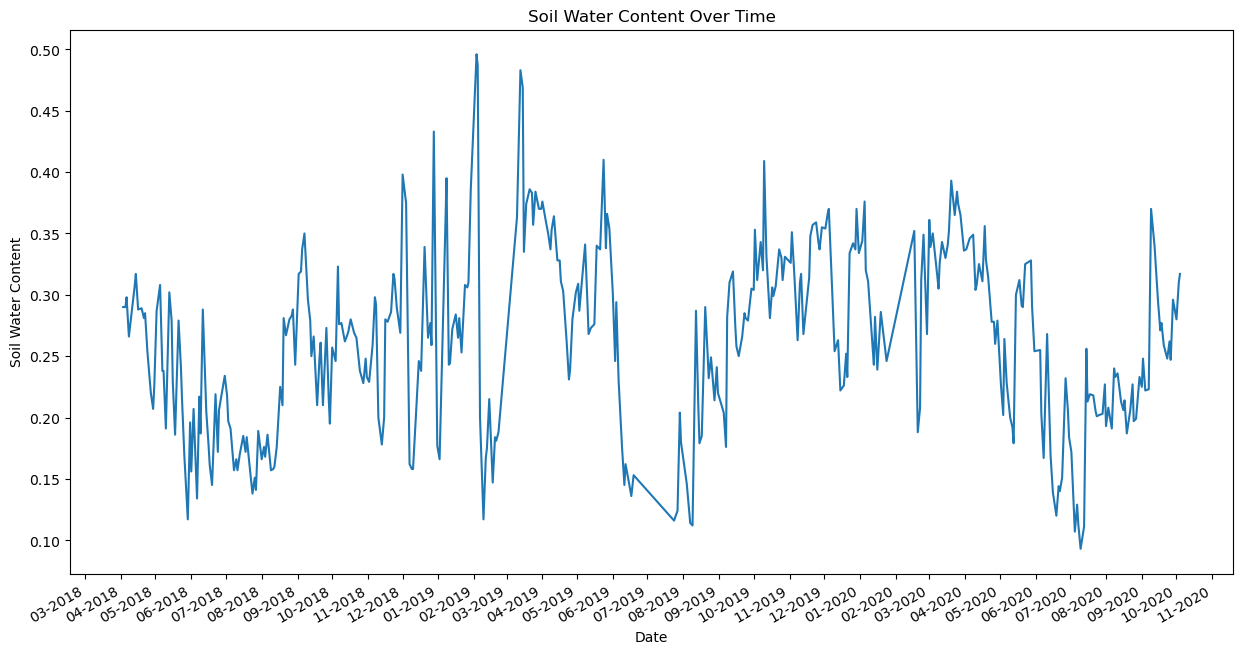

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Normalize the JSON response and create a DataFrame
series = pd.json_normalize(swc_stats_response[0]["data"])
series['date'] = pd.to_datetime(series['interval.from']).dt.date
series.set_index('date', inplace=True)
series = series[['outputs.SWC.bands.B0.stats.mean']].rename({'outputs.SWC.bands.B0.stats.mean':'SWC'}, axis=1)
series['SWC'] = pd.to_numeric(series['SWC'], errors='coerce')
series = series['SWC'].interpolate()  # Interpolating missing values

# Plot the series
ax.plot(series)

# Setting the title and labels
ax.set_title("Soil Water Content Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Soil Water Content")

# Set major locator and formatter to display month and year
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

# Optional: set minor locator and formatter if you want minor ticks
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_minor_formatter(mdates.DateFormatter(''))

plt.gcf().autofmt_xdate()

plt.show()

Plot the cumulative SWC against the cumulative growing degree days to see how much water was available to the crops at the same point in development each season. For example here we can see SWC was higher in 2019 before becoming lower than the 2020 season later in the crops development. 

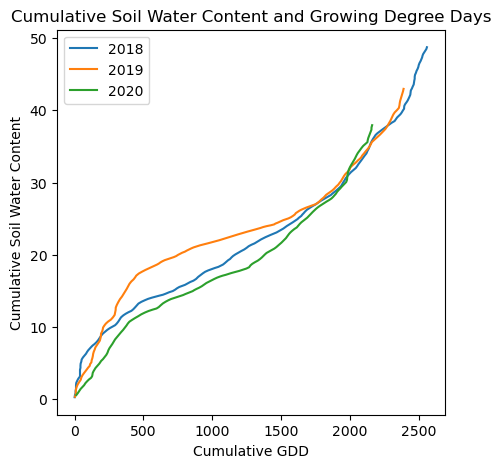

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for season, df in gdd_data.items():

    combined = pd.merge(df, series, left_index=True, right_index=True, how = 'left')
    ax.plot(combined.GDD, combined.SWC.cumsum(), label = f"{season}")

ax.set_title("Cumulative Soil Water Content and Growing Degree Days")
ax.set_ylabel('Cumulative Soil Water Content')
ax.set_xlabel('Cumulative GDD')
plt.legend()
plt.show()